# About merged otu table

Attempt to describe the merged otu table.

In [1]:
import logging

import biom
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import project_directory
from src.database import get_session, Sample

I can retrieve information reling on the database made with metadata: let's connect to SQLite database and retrieve the information:

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['KR9NH_sample_100' 'KR9NH_sample_10' 'KR9NH_sample_11' 'KR9NH_sample_12'
 'KR9NH_sample_13' 'KR9NH_sample_14' 'KR9NH_sample_15' 'KR9NH_sample_16'
 'KR9NH_sample_17' 'KR9NH_sample_18']


Now select from database relying on sample names: create a dictionary with sample names as keys and tissue as values:

In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}
sample2dataset = {sample.sample_id: sample.dataset.id for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)
metadata['dataset'] = metadata.index.map(sample2dataset)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7f296e319120>, {'tissue': 'gut', 'dataset': 54}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7f296e318d60>, {'tissue': 'gut', 'dataset': 54}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7f296e3191c0>, {'tissue': 'gut', 'dataset': 54}))


In [7]:
# collect unique tissue-dataset pairs
tissue_dataset_table = metadata[['tissue', 'dataset']].drop_duplicates().sort_values(['tissue', 'dataset'])
tissue_dataset_table.reset_index(drop=True)


,tissue,dataset
0,feces,47
1,gut,54
2,hindgut,3
3,hindgut,13
4,milk,15
5,milk,16
6,milk,53
7,rumen,2
8,rumen,14
9,rumen,48


## Samples by tissue

Check how many samples per tissue we have:

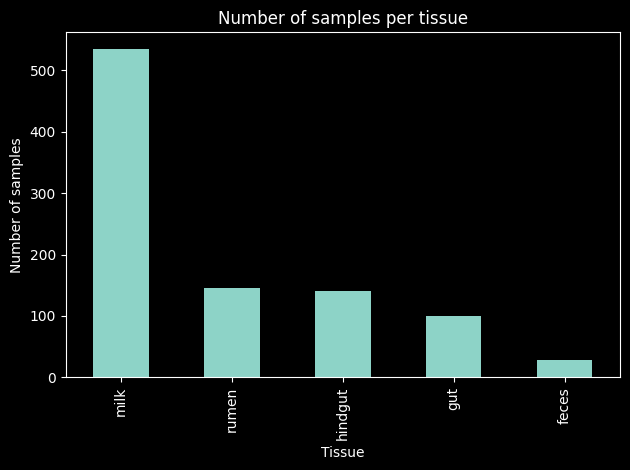

In [8]:
metadata["tissue"].value_counts().plot(kind='bar')
plt.title("Number of samples per tissue")
plt.xlabel("Tissue")
plt.ylabel("Number of samples")
plt.tight_layout()

## Samples by dataset

How many samples per datasets?

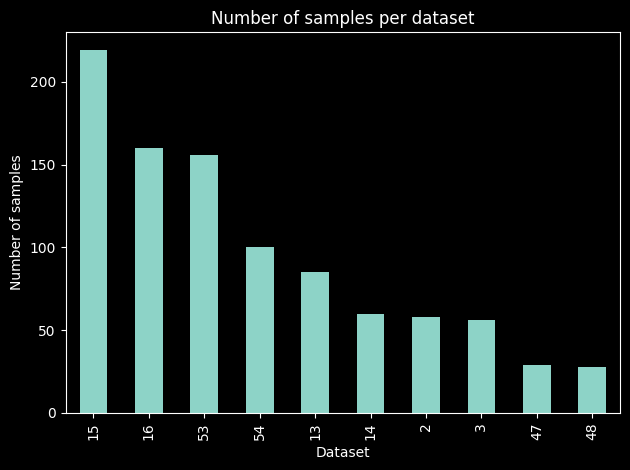

In [9]:
metadata["dataset"].value_counts().plot(kind='bar')
plt.title("Number of samples per dataset")
plt.xlabel("Dataset")
plt.ylabel("Number of samples")
plt.tight_layout()

## Heatmap of 1000 most abundant ASVs

Let's try to do an heatmap: we have a lot of data, focus only on the most abundant ASVs:

In [10]:
# Convert the biom table to a dense numpy array
data = table.matrix_data.toarray()

# Select the 1000 most abundant rows
row_sums = data.sum(axis=1)
top_1000_indices = np.argsort(row_sums)[-1000:]
top_1000_data = data[top_1000_indices, :]

Create a clustermap for tissue:

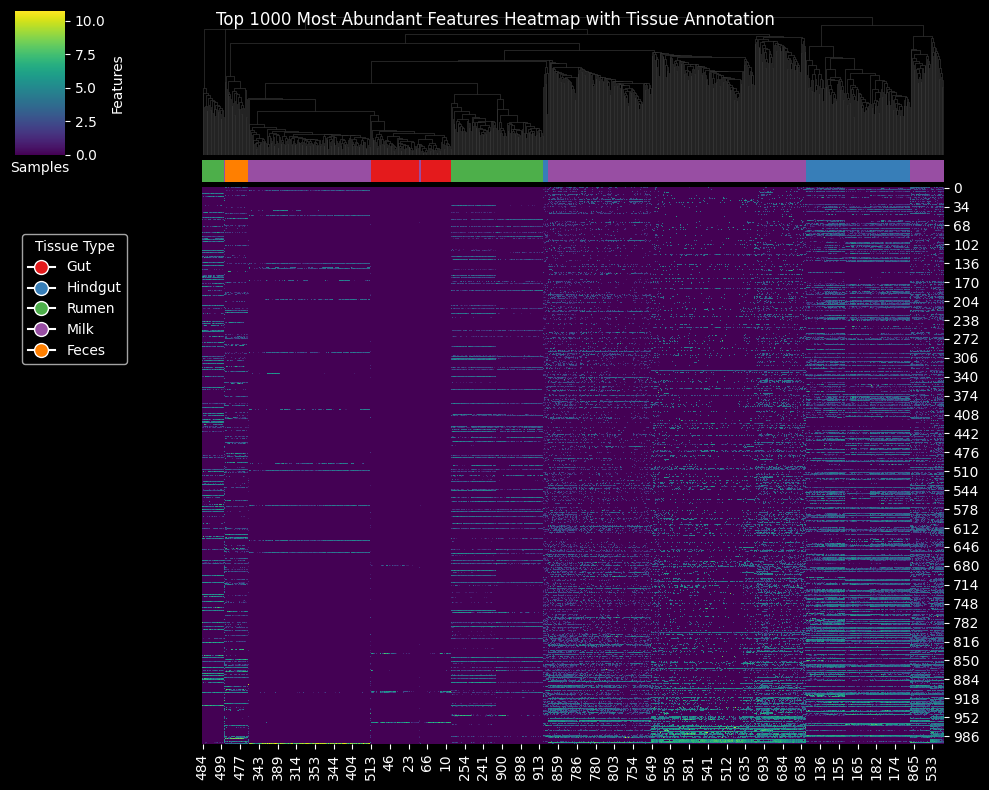

In [11]:
# collect unique tissue types
unique_tissues = metadata['tissue'].unique()

# generate a color map for the tissue types
palette = sns.color_palette("Set1", len(unique_tissues))
tissue_color_map = dict(zip(unique_tissues, palette))

# Create a clustermap with seaborn
sns.clustermap(
    np.log1p(top_1000_data),
    cmap='viridis',
    figsize=(10, 8),
    row_cluster=False,
    col_cluster=True,
    col_colors=metadata['tissue'].map(tissue_color_map).to_numpy(),
)

# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=tissue.capitalize(),
               markersize=10, markerfacecolor=tissue_color_map[tissue])
    for tissue in unique_tissues
]

plt.legend(handles=handles, title='Tissue Type', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 1000 Most Abundant Features Heatmap with Tissue Annotation', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

Do the same as above, but adding information about datasets:

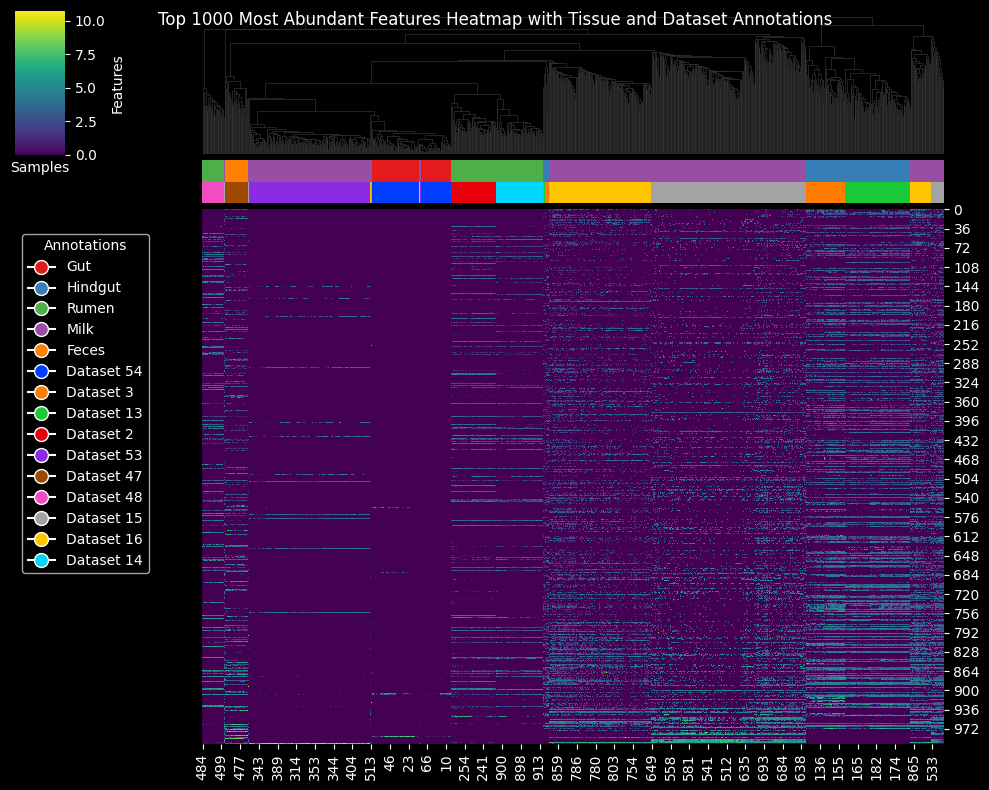

In [12]:
# collect unique tissue types
unique_tissues = metadata['tissue'].unique()

# generate a color map for the tissue types
palette = sns.color_palette("Set1", len(unique_tissues))
tissue_color_map = dict(zip(unique_tissues, palette))

# collect unique dataset ids
unique_datasets = metadata['dataset'].unique()

# generate a color map for the dataset ids
palette = sns.color_palette("bright", len(unique_datasets))
dataset_color_map = dict(zip(unique_datasets, palette))

# Create a clustermap with seaborn including both tissue and dataset annotations
sns.clustermap(
    np.log1p(top_1000_data),
    cmap='viridis',
    figsize=(10, 8),
    row_cluster=False,
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map(tissue_color_map).to_numpy(),
        metadata['dataset'].map(dataset_color_map).to_numpy(),
    ],
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=tissue.capitalize(),
               markersize=10, markerfacecolor=tissue_color_map[tissue])
    for tissue in unique_tissues
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Dataset {dataset}", markersize=10,
               markerfacecolor=dataset_color_map[dataset])
    for dataset in unique_datasets
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 1000 Most Abundant Features Heatmap with Tissue and Dataset Annotations', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

## Heatmap of 250 most abundant ASVs

Try to do another clustermap for the most 250 abundant ASVs:

In [13]:
row_sums = data.sum(axis=1)
top_250_indices = np.argsort(row_sums)[-100:]
top_250_data = data[top_250_indices, :]

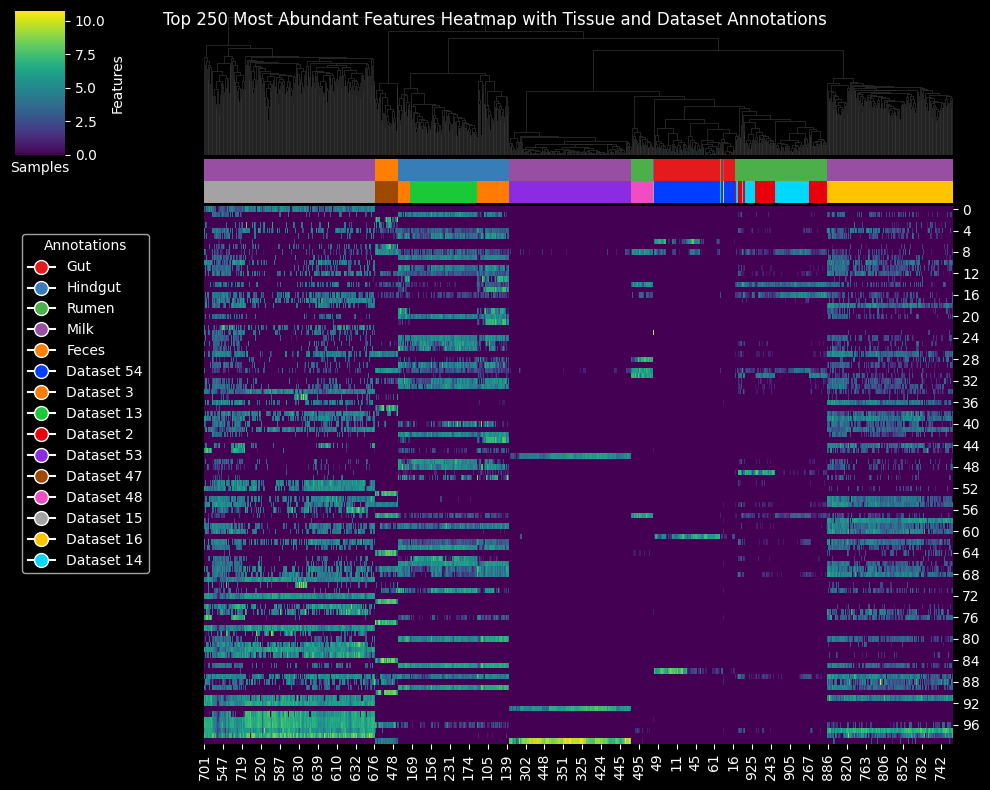

In [14]:
# collect unique tissue types
unique_tissues = metadata['tissue'].unique()

# generate a color map for the tissue types
palette = sns.color_palette("Set1", len(unique_tissues))
tissue_color_map = dict(zip(unique_tissues, palette))

# collect unique dataset ids
unique_datasets = metadata['dataset'].unique()

# generate a color map for the dataset ids
palette = sns.color_palette("bright", len(unique_datasets))
dataset_color_map = dict(zip(unique_datasets, palette))

# Create a clustermap with seaborn including both tissue and dataset annotations
sns.clustermap(
    np.log1p(top_250_data),
    cmap='viridis',
    figsize=(10, 8),
    row_cluster=False,
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map(tissue_color_map).to_numpy(),
        metadata['dataset'].map(dataset_color_map).to_numpy()
    ],
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=tissue.capitalize(),
               markersize=10, markerfacecolor=tissue_color_map[tissue])
    for tissue in unique_tissues
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Dataset {dataset}", markersize=10,
               markerfacecolor=dataset_color_map[dataset])
    for dataset in unique_datasets
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))

# Add title and labels
plt.suptitle('Top 250 Most Abundant Features Heatmap with Tissue and Dataset Annotations', ha='center')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.show()

## Clustermap of Sample Correlations

Try to do a different thing: calculate the clustermap using the correlation matrix between samples (the transpose of the otu table):

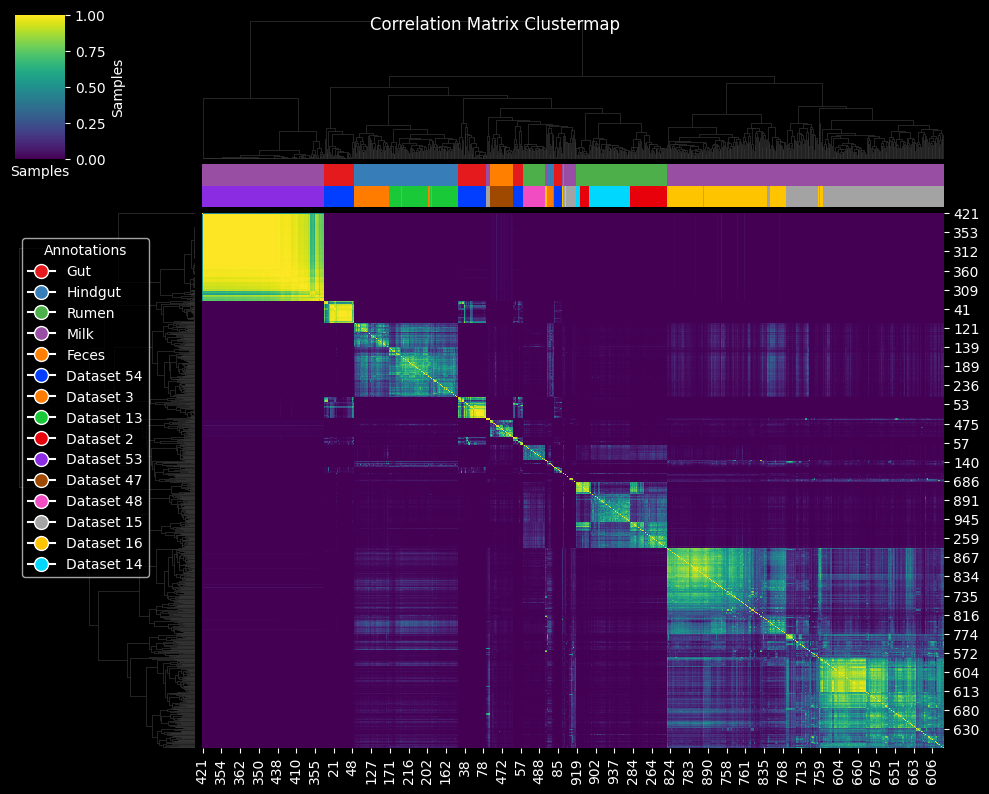

In [15]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# collect unique tissue types
unique_tissues = metadata['tissue'].unique()

# generate a color map for the tissue types
palette = sns.color_palette("Set1", len(unique_tissues))
tissue_color_map = dict(zip(unique_tissues, palette))

# collect unique dataset ids
unique_datasets = metadata['dataset'].unique()

# generate a color map for the dataset ids
palette = sns.color_palette("bright", len(unique_datasets))
dataset_color_map = dict(zip(unique_datasets, palette))

# Create a clustermap with seaborn using the correlation matrix
sns.clustermap(
    correlation_matrix,
    cmap='viridis',
    figsize=(10, 8),
    row_cluster=True,
    col_cluster=True,
    col_colors=[
        metadata['tissue'].map(tissue_color_map).to_numpy(),
        metadata['dataset'].map(dataset_color_map).to_numpy()
    ],
)

# Create a custom legend for tissue
tissue_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=tissue.capitalize(),
               markersize=10, markerfacecolor=tissue_color_map[tissue])
    for tissue in unique_tissues
]

# Create a custom legend for dataset
dataset_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Dataset {dataset}", markersize=10,
               markerfacecolor=dataset_color_map[dataset])
    for dataset in unique_datasets
]

plt.legend(handles=tissue_handles + dataset_handles, title='Annotations', loc='upper left', bbox_to_anchor=(0, -0.5))


# Add title and labels
plt.suptitle('Correlation Matrix Clustermap', ha='center')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

In [16]:
print(f"Data shape: {data.shape}")  # [n_features, n_samples]
print(f"Data.T shape: {data.T.shape}")  # [n_samples, n_features]
print(f"Correlation matrix shape: {correlation_matrix.shape}")  # [n_samples, n_samples]
print(f"Number of samples: {len(samples)}")  # should match

Data shape: (164694, 951)
Data.T shape: (951, 164694)
Correlation matrix shape: (951, 951)
Number of samples: 951
